# Import Packages

In [5]:
#%matplotlib widget
import tensorflow as tf
import keras as keras
import keras.backend as K
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
from tqdm import trange
import h5py

from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation

# Define Parameters

In [10]:
SNR = 175
n_elements = 128
n_elements_brain = 32

ob_weight = 100
Nth = 10
n_noise_realizations = 10

upper_bound = [1,1,500,1500] #Set upper bound on parameters c1, c2, T21, T22, respectively
initial = (0.5, 0.5, 250, 750) #Set initial guesses
initial_brain = (0.5, 0.5, 20, 100)
agg_array = np.array([1,1,1/ob_weight, 1/ob_weight])

tdata = np.linspace(0, 635, n_elements)
t_increment_brain = 11.3
tdata_brain = np.linspace(t_increment_brain, (n_elements_brain)*(t_increment_brain), n_elements_brain)

#Two parameter definition of s(t) with regularization parameter lambda
def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_tilde(lam, SA = 1):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    def Gt_lam(t, con1, con2, tau1, tau2):
        return np.append(G(t, con1, con2, tau1, tau2), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam

noise_sd = 1/SNR

def noise(sd):
    return np.random.normal(0, sd, n_elements)

def noise_brain(sd):
    return np.random.normal(0, sd, n_elements_brain)

c1_set = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
c2_set = 1 - c1_set
T21_set = np.array([10, 20, 30, 40, 50, 60])
T22_set = np.array([70, 85, 100, 120, 150, 200])
n_param_sets = c1_set.size * T21_set.size * T22_set.size

SNR_set = np.array([10, 50, 100, 175, 300])

n_datasets = 500

# Define useful functions

In [11]:
def estimate_parameters(data, lam):
    data_tilde = np.append(data, [0,0,0,0])
    
    (rc1e, rc2e, rT21e, rT22e), rcov = curve_fit(G_tilde(lam), tdata, data_tilde, bounds = (0, upper_bound), p0=initial, max_nfev = 4000)
    
    if rT22e > rT21e:
        c1est = rc1e
        c2est = rc2e
        T21est = rT21e
        T22est = rT22e
    else:
        c1est = rc2e
        c2est = rc1e
        T21est = rT22e
        T22est = rT21e
        
    return c1est, c2est, T21est, T22est

def min_lambda(data, c1, c2, T21, T22, lambdas = np.logspace(-7, 3, 51), agg_arr = np.array([1, 1,1/ob_weight,1/ob_weight])):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    p_true = np.array([c1, c2, T21, T22])
    abs_error_list = []
    estimates = []
    for lam in lambdas:
        est = np.array(estimate_parameters(data, lam))
        estimates.append(est)
        error = np.absolute(est-p_true)
        abs_error_list.append(error.dot(agg_arr))
    
    min_error_idx = np.argmin(abs_error_list)
    min_error_est = estimates[min_error_idx]
    min_error_lambda = lambdas[min_error_idx]

    return min_error_est, min_error_lambda

def min_bias_estimates(c1, c2, T21, T22, n=100, lambdas = np.logspace(-7,3, 51), agg_arr = [1,1,0.01,0.01]):
    #Returns aggregate bias, variance, and MSE of the estimates generated 
    #from using the lambda which minimizes bias for each noise realization
    agg_arr = np.array(agg_arr)
    underlying = G(tdata, c1, c2, T21, T22)
    
    bias = np.zeros(4)
    variance = np.zeros(4)
    MSE = np.zeros(4)
    
    min_bias_lambdas = []
    min_bias_estimates = []
    for i in range(n):
        np.random.seed(i)
        data = underlying + noise(noise_sd)
        agg_bias_list = []
        temp_estimates = []
        for l in range(len(lambdas)):
            lam = lambdas[l]
            est = np.array(estimate_parameters(data, lam))
            temp_estimates.append(est)
            agg_bias_list.append(np.absolute(est-[c1,c2,T21,T22]).dot(agg_arr))
        
        min_bias_idx = np.argmin(agg_bias_list)
        
        min_bias_lambdas.append(lambdas[min_bias_idx])
        min_bias_estimates.append(temp_estimates[min_bias_idx])
    
    min_bias_estimates = np.array(min_bias_estimates)
    
    c1est = min_bias_estimates[:,0]
    c2est = min_bias_estimates[:,1]
    T21est = min_bias_estimates[:,2]
    T22est = min_bias_estimates[:,3]
    
    bias[0] = (c1est - [c1]*n).sum()/n
    bias[1] = (c2est - [c2]*n).sum()/n
    bias[2] = (T21est - [T21]*n).sum()/n
    bias[3] = (T22est - [T22]*n).sum()/n
    
    variance[0] = statistics.pvariance(c1est)
    variance[1] = statistics.pvariance(c2est)
    variance[2] = statistics.pvariance(T21est)
    variance[3] = statistics.pvariance(T22est)
    
    MSE = bias**2 + variance
    
    agg_bias = np.absolute(bias).dot(agg_arr)
    agg_variance = variance.dot(agg_arr**2)
    agg_MSE = MSE.dot(agg_arr**2)
    
    return agg_bias, agg_variance, agg_MSE, np.array(min_bias_lambdas)

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def cov_matrix(con1, con2, tau1, tau2, noise_sd):
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2)
    covariance = np.linalg.inv(jacobians)
    return noise_sd**2*covariance

def estimate_NLLS_brain(data, lam=0, expt_knowledge = [0,0,0,0]):
    SA = data[0]
    data_tilde = np.append(data, lam*np.array(expt_knowledge))
    (rc1e, rc2e, rT21e, rT22e), rcov = curve_fit(
        G_tilde(lam, SA = SA), tdata_brain, data_tilde, bounds = ([0,0,0,0], [SA, SA, 40, 300]), p0=initial_brain, max_nfev = 4000)
    
    if rT22e > rT21e:
        c1est = rc1e
        c2est = rc2e
        T21est = rT21e
        T22est = rT22e
    else:
        c1est = rc2e
        c2est = rc1e
        T21est = rT22e
        T22est = rT21e
    #Assume c1 + c2 = 1
    ci_sum = c1est + c2est
    c1est = c1est/ci_sum
    c2est = c2est/ci_sum
        
    return c1est, c2est, T21est, T22est

def min_lambda_brain(data, c1, c2, T21, T22, lambdas = np.logspace(-7, 3, 51), agg_arr = np.array([1, 1,1/ob_weight,1/ob_weight])):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    p_true = np.array([c1, c2, T21, T22])
    abs_error_list = []
    estimates = []
    for lam in lambdas:
        est = np.array(estimate_NLLS_brain(data, lam=lam))
        estimates.append(est)
        error = np.absolute(est-p_true)
        abs_error_list.append(error.dot(agg_arr))
    
    min_error_idx = np.argmin(abs_error_list)
    min_error_est = estimates[min_error_idx]
    min_error_lambda = lambdas[min_error_idx]

    return min_error_est, min_error_lambda

def min_bias_estimates_brain(c1, c2, T21, T22, datasets, lambdas = np.logspace(-7,3, 51), agg_arr = [1,1,0.01,0.01]):
    #Returns lambdas giving minimum aggregate absolute error for datasets generated from parameters c1, c2, T21, T22
    n_datasets = datasets.shape[0]
    p_true = [c1, c2, T21, T22]
    agg_arr = np.array(agg_arr)
    underlying = G(tdata_brain, c1, c2, T21, T22)
    
    min_bias_lambdas = []
    for i in range(n_datasets):
        data = datasets[i,:]
        agg_bias_list = []
        temp_estimates = []
        for l in range(len(lambdas)):
            lam = lambdas[l]
            est = np.array(estimate_NLLS_brain(data, lam=lam))
            temp_estimates.append(est)
            agg_bias_list.append(np.absolute(est-p_true).dot(agg_arr))
        
        min_bias_idx = np.argmin(agg_bias_list)
        
        min_bias_lambdas.append(lambdas[min_bias_idx])
    
    return np.array(min_bias_lambdas)

# Generate data sets

In [13]:
#For each true parameter value, generate n_datasets at a certain SNR defined above
iterator = 1
for SNR in SNR_set:
    noise_sd = 1/SNR
    with h5py.File('DNN_TrainingData//DNN Brain Datasets 1 norm SNR %s.hdf5'%SNR,'a') as f2:
        for c1 in c1_set:
            c2 = 1-c1
            for iT21 in trange(T21_set.size):
                T21 = T21_set[iT21]
                for T22 in T22_set:
                    noiseless_curve = G(tdata_brain, c1, c2, T21, T22)
                    #Generate the datasets from the underlying curve
                    datasets = []
                    for i in range(n_datasets):
                        np.random.seed(i)
                        data = noiseless_curve + noise_brain(noise_sd)
                        #For brain data, normalize so that the first point is at 1
                        data = data/data[0]
                        datasets.append(data)
    
                    datasets = np.array(datasets)
                    #Save the data points from each dataset, denoted 'x'
                    try:
                        dset = f2.create_dataset('{},{},{},{},x'.format(c1,c2,T21,T22),data=datasets)
                        #Save the optimal lambdas for each dataset, denoted 'y'
                        min_error_lambdas = min_bias_estimates_brain(c1, c2, T21, T22, datasets)
                        dset = f2.create_dataset('{},{},{},{},y'.format(c1,c2,T21,T22),data=min_error_lambdas)
                        iterator += 1
                    except:
                        iterator += 1

100%|██████████| 6/6 [00:00<00:00, 13.64it/s]


In [15]:
with h5py.File('DNN_TrainingData//DNN Brain Datasets 1 norm ALL SNR.hdf5','a') as f1:
    SNR_lbl = '300'
    with h5py.File('DNN_TrainingData//DNN Brain Datasets 1 norm SNR %s.hdf5'%(SNR_lbl),'a') as f2:
        keys = list(f2.keys())
        for key in keys:
            dset = f2[key]
            dset_lbl = SNR_lbl + ',' + key
            f1.create_dataset(dset_lbl,data=dset)
    keys = list(f1.keys())
    print(keys)

ValueError: Unable to create dataset (name already exists)

In [17]:
with h5py.File('DNN_TrainingData//DNN Brain Datasets 1 norm SNR 300.hdf5','a') as f2:
    print(len(f2.keys()))

360


In [19]:
#Load in the data into x and y arrays
x = []
y = []
with h5py.File('DNN_TrainingData//DNN Brain Datasets 1 norm ALL SNR.hdf5','a') as f2:
    keys = list(f2.keys())
    n_param_sets = int(len(keys)/2)
    i = 0
    for key in keys:
        if i%2 == 0:
            x.append(np.array(f2[key]))
        if i%2 == 1:
            y.append(np.array(f2[key]))
        i += 1
#Reshape the arrays, given many different sets of true parameter values
x = np.reshape(np.array(x), (n_param_sets*n_datasets,n_elements_brain))
y = np.reshape(y, n_param_sets*n_datasets)
y_log = np.log10(y)

# Compile and train the DNN

In [20]:
#Set dropout fraction
dd = 0.2
#Split data randomly into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y_log, test_size = 0.2)

n_features = x_train.shape[1]

#Initialize the model
K.clear_session()
model = Sequential()
model.add(Dense(75, kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
#Output of first layer
model.add(Dropout(dd))
model.add(Dense(50, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dropout(dd))
model.add(Dense(25, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dropout(dd))
model.add(Dense(12, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dropout(dd))
model.add(Dense(6, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('sigmoid')) #Test removing
model.add(Dropout(dd))
model.add(Dense(75, kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dense(1))

#Use an adaptive learning rate which decreases when loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.0000001)
#Define different optimizers
opt_SGD = tf.keras.optimizers.SGD(learning_rate=0.0001)
opt_Adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
#Compile the model with one of the above optimizers and MSE as the loss function
model.compile(optimizer=opt_Adam, loss='mse')
#Calculate initial training and testing errors
init_train_loss = model.evaluate(x_train, y_train, verbose=0)
init_error = model.evaluate(x_test, y_test, verbose=0)
print('Initial training loss:', init_train_loss)
print('Initial testing loss:', init_error)

#Manually iterate through epochs and train the network
epochs = 25
#Define what you would like to use for validation
x_val = x_test
y_val = y_test
train_loss = np.zeros(epochs)
val_loss = np.zeros(epochs)

for epoch in trange(epochs):
    train_loss[epoch] = np.mean((model(x_train)[:,0]-y_train)**2)
    val_loss[epoch] = np.mean((model(x_val)[:,0]-y_val)**2)

    model.fit(x_train, y_train, verbose=0, callbacks=[reduce_lr])

Initial training loss: 10.353979110717773
Initial testing loss: 10.327858924865723


100%|██████████| 25/25 [17:40<00:00, 42.41s/it]


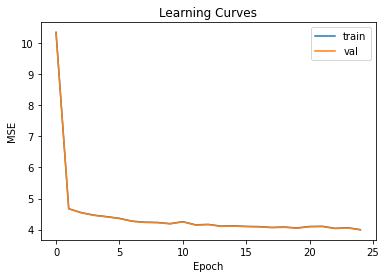

In [21]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.show()

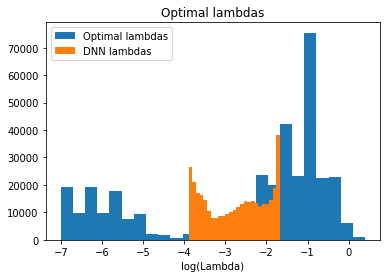

In [22]:
plt.hist(y_train, bins=25, label = 'Optimal lambdas')
plt.hist((np.array(model(x_train))), bins=25, label = 'DNN lambdas')
plt.title('Optimal lambdas')
plt.xlabel('log(Lambda)')
plt.legend()
plt.show()

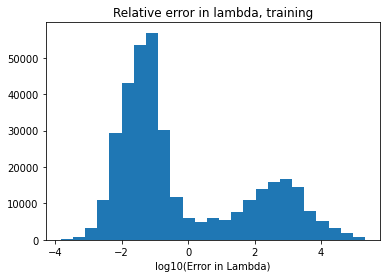

In [23]:
plt.hist(np.array(model(x_train)[:,0])-(y_train), bins=25)
plt.title('Relative error in lambda, training')
plt.xlabel('log10(Error in Lambda)')
plt.show()

In [24]:
model.save('DNN Networks//brain reg model 1 norm ALL SNR.h5')

NameError: name 'lin_comb_hist' is not defined

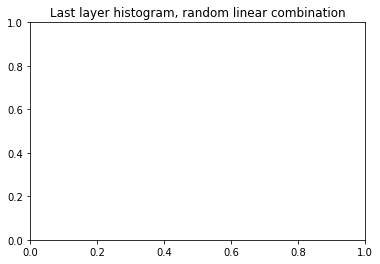

In [25]:
weights = np.random.uniform(0,1,6)
weights = weights/weights.sum()
plt.title('Last layer histogram, random linear combination')
plt.hist(lin_comb_hist, bins = 25)
plt.ylabel('Counts')
plt.xlabel('Weights: %s'%weights.round(2))
plt.show()

# Use a DNN to obtain a PDF of lambda

## Define the loss function and validation method

In [26]:
def bin_data(y, n_bins, bins):
    #Use the binning scheme to create a set of one-hot arrays, v
    y_idx = np.digitize(y, bins)
    v = np.zeros((y_idx.size, n_bins))
    v[np.arange(y_idx.size),y_idx] = 1

    return v
    
def loss_fun(v_true, p_pred):
    #Given: v_true, the true one-hot vector, and p_pred, the predictions from the DNN, caluculate cross entropy for each data point
    cross_entropy = np.multiply(v_true,np.log10(p_pred)) + np.multiply((1-v_true),(np.log10(1-p_pred)))
    loss = -np.sum(cross_entropy,axis=-1)
    return loss

def q(idxs, bins):
    #Takes an array of indices and converts it back to the binning scheme
    output = []
    for idx in idxs:
        if idx>0:
            bin_center = (bins[idx]+bins[idx-1])/2
        else:
            bin_center = bins[idx]
        output.append(bin_center)
    return np.array(output)

def MAP_lam(p_pred, bins):
    #Calculates maximum a posteriori lambda output from the DNN for each data point
    #Outputs the log10 of lambda
    max_idx = np.argmax(p_pred, axis=-1)
    log_lambdas = q(max_idx, bins)
    return log_lambdas

def MMSE_lam(p_pred, bins):
    #Calculates a weighted average of the predicted lambdas
    #Outputs the log10 of lambda
    return np.array(p_pred)@bins

In [333]:
test = np.linspace(-8, 2.9, 1000)
#v = bin_data(test, n_bins, bins)
max_vals_vector = []
for t in test:
    v = bin_data(t, n_bins, bins)
    max_idx = np.argmax(v, axis=-1)
    max_val = q(max_idx, bins)# - 1/8
    max_vals_vector.append(max_val)

## Load in the data sets and convert the solutions to binned one-hot arrays

In [27]:
bin_min = -8
bin_max = 3
n_bins = 45
bins = np.linspace(bin_min,bin_max,n_bins)
with h5py.File('DNN Datasets//DNN Datasets SNR 10.hdf5','a') as f2:
    keys = list(f2.keys())
    n_param_sets = int(len(keys)/2)
    x_pdf = []
    y_pdf = []
    i = 0
    #Load in the data and the optimal lambdas
    for key in keys:
        dset = np.array(f2[key])
        if i%2 == 0:
            x_pdf.append(dset)
        if i%2 == 1:
            y_pdf.append(dset)
        i += 1
    #Reshape the data    
    x_pdf = np.array(x_pdf)
    x_pdf = np.reshape(x_pdf, (n_param_sets*n_datasets,n_elements))
    #Reshape the optimal lambdas
    y_pdf = np.log10(np.reshape(y_pdf, n_param_sets*n_datasets))
    
    #Split data randomly into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x_pdf, y_pdf, test_size = 0.2)

    #Use the binning scheme to create a set of one-hot arrays, v_train and v_test
    #y_idx_train = np.digitize(y_train, bins)    
    #v_train = np.zeros((y_idx_train.size, n_bins))
    #v_train[np.arange(y_idx_train.size),y_idx_train] = 1

    #y_idx_test = np.digitize(y_test, bins)    
    #v_test = np.zeros((y_idx_test.size, n_bins))
    #v_test[np.arange(y_idx_test.size),y_idx_test] = 1
    
    v_train = bin_data(y_train, n_bins, bins)
    v_test = bin_data(y_test, n_bins, bins)

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = 'DNN Datasets//DNN Datasets SNR 10.hdf5', errno = 2, error message = 'No such file or directory', flags = 15, o_flags = 502)

## Compile the DNN

In [41]:
#Set dropout fraction
dd = 0.2

n_features = x_train.shape[1]

#Initialize the model
K.clear_session()
model_pdf = Sequential()
model_pdf.add(Dense(75, kernel_initializer='he_normal', input_shape=(n_features,)))
#model_pdf.add(BatchNormalization())
model_pdf.add(Activation('sigmoid'))
#Output of first layer
model_pdf.add(Dropout(dd))
model_pdf.add(Dense(50, kernel_initializer='he_normal'))
#model_pdf.add(BatchNormalization())
model_pdf.add(Activation('sigmoid'))
model_pdf.add(Dropout(dd))
model_pdf.add(Dense(25, kernel_initializer='he_normal'))
#model_pdf.add(BatchNormalization())
model_pdf.add(Activation('sigmoid'))
model_pdf.add(Dropout(dd))
model_pdf.add(Dense(n_bins))
model_pdf.add(Activation('softmax'))

model_pdf.compile(optimizer='adam', loss="binary_crossentropy")

## Train the network

In [42]:
## Manually iterate through epochs and train the network
init_train_loss = model_pdf.evaluate(x_train, v_train, verbose=0)
init_val_loss = model_pdf.evaluate(x_test, v_test, verbose=0)
print('Initial training loss:', init_train_loss)
print('Initial validation loss:', init_val_loss)

epochs = 250
train_loss = np.zeros(epochs+1)
train_loss[0] = init_train_loss
val_loss = np.zeros(epochs+1)
val_loss[0] = init_val_loss
for epoch in trange(epochs):
    train_loss[epoch+1] = model_pdf.evaluate(x_train, v_train, verbose=0)
    val_loss[epoch+1] = model_pdf.evaluate(x_test, v_test, verbose=0)
    model_pdf.fit(x_train, v_train, verbose=0)

  0%|                                                                                          | 0/250 [00:00<?, ?it/s]

Initial training loss: 0.10436653345823288
Initial validation loss: 0.10421758890151978


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [12:10<00:00,  2.92s/it]


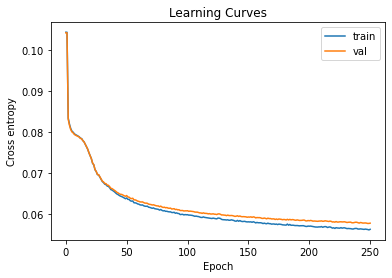

In [43]:
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross entropy')
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.show()

In [44]:
test_idx = 100
test_output = model_pdf(x_test[test_idx:test_idx+1])
test_true = y_test[test_idx:test_idx+1]
print(test_true)

[-5.6]


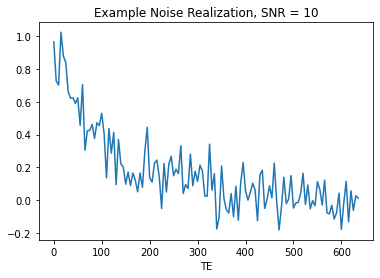

In [45]:
plt.plot(tdata, x_test[test_idx])
plt.title('Example Noise Realization, SNR = 10')
plt.xlabel('TE')
plt.show()

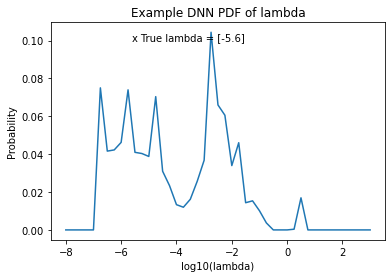

In [47]:
plt.plot(bins, test_output[0,:])
plt.title('Example DNN PDF of lambda')
plt.text(test_true, 0.1, 'x True lambda = %s'%test_true)
plt.xlabel('log10(lambda)')
plt.ylabel('Probability')
plt.show()

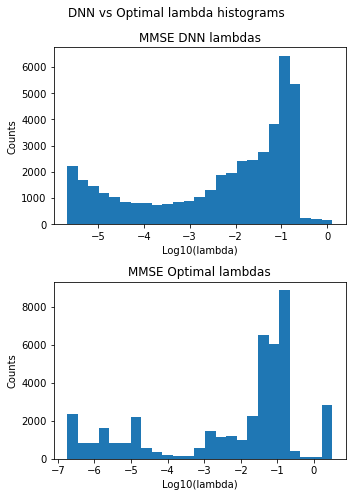

In [48]:
output_pdf = model_pdf(x_train)
fig, (ax1, ax2) = plt.subplots(2,figsize = (5,7),tight_layout=True)
fig.suptitle('DNN vs Optimal lambda histograms')

ax1.hist(MMSE_lam(output_pdf, bins), bins=25)
ax1.set_title('MMSE DNN lambdas')
ax1.set_xlabel('Log10(lambda)')
ax1.set_ylabel('Counts')

ax2.hist(MMSE_lam(v_train, bins), bins=25)
ax2.set_title('MMSE Optimal lambdas')
ax2.set_xlabel('Log10(lambda)')
ax2.set_ylabel('Counts')

plt.show()

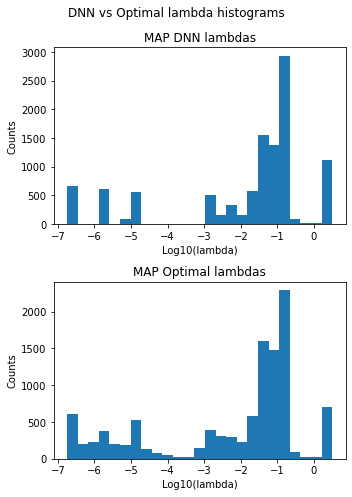

In [316]:
output_pdf = model_pdf(x_test)
fig, (ax1, ax2) = plt.subplots(2,figsize = (5,7),tight_layout=True)
fig.suptitle('DNN vs Optimal lambda histograms')

ax1.hist(MAP_lam(output_pdf, bins), bins=25)
ax1.set_title('MAP DNN lambdas')
ax1.set_xlabel('Log10(lambda)')
ax1.set_ylabel('Counts')

ax2.hist(MAP_lam(v_test, bins), bins=25)
ax2.set_title('MAP Optimal lambdas')
ax2.set_xlabel('Log10(lambda)')
ax2.set_ylabel('Counts')

plt.show()

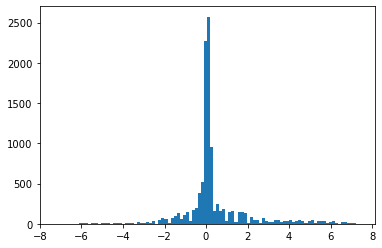

In [354]:
output_lams = MAP_lam(model_pdf(x_test),bins)
error = (output_lams-y_test)
plt.hist(error, bins=100)
plt.show()

In [49]:
model_pdf.save('DNN Networks//lam pdf reg_model 45 bins dropout 3-2.h5')

## Iterating through bin sizes, save models to compare performance

In [7]:
bin_min = -8
bin_max = 3
with h5py.File('DNN Datasets//DNN Datasets SNR 10.hdf5','a') as f2:
    keys = list(f2.keys())
    n_param_sets = int(len(keys)/2)
    x_pdf = []
    y_pdf = []
    i = 0
    #Load in the data and the optimal lambdas
    for key in keys:
        dset = np.array(f2[key])
        if i%2 == 0:
            x_pdf.append(dset)
        if i%2 == 1:
            y_pdf.append(dset)
        i += 1
    #Reshape the data    
    x_pdf = np.array(x_pdf)
    x_pdf = np.reshape(x_pdf, (n_param_sets*n_datasets,n_elements))
    #Reshape the optimal lambdas
    y_pdf = np.log10(np.reshape(y_pdf, n_param_sets*n_datasets))
    
    #Split data randomly into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x_pdf, y_pdf, test_size = 0.2)

In [11]:
bin_sizes = [12, 23, 34, 45, 56, 67, 78, 89, 100]
epochs = 500
train_loss_each_bin = np.zeros((len(bin_sizes),epochs+1))
val_loss_each_bin = np.zeros((len(bin_sizes),epochs+1))
for i_bin in range(len(bin_sizes)):
    bin_num = bin_sizes[i_bin]
    #Set the number of bins and define the solution vector v
    bins = np.linspace(bin_min, bin_max, bin_num)
    v_train = bin_data(y_train, bin_num, bins)
    v_test = bin_data(y_test, bin_num, bins)
    
    #Compile the network with the correct number of outputs
    #Set dropout fraction
    dd = 0.2

    n_features = x_train.shape[1]

    #Initialize the model
    K.clear_session()
    model_pdf = Sequential()
    model_pdf.add(Dense(75, kernel_initializer='he_normal', input_shape=(n_features,)))
    model_pdf.add(BatchNormalization())
    model_pdf.add(Activation('sigmoid'))
    #Output of first layer
    #model_pdf.add(Dropout(dd))
    model_pdf.add(Dense(50, kernel_initializer='he_normal'))
    model_pdf.add(BatchNormalization())
    model_pdf.add(Activation('sigmoid'))
    #model_pdf.add(Dropout(dd))
    model_pdf.add(Dense(25, kernel_initializer='he_normal'))
    model_pdf.add(BatchNormalization())
    model_pdf.add(Activation('sigmoid'))
    #model_pdf.add(Dropout(dd))
    model_pdf.add(Dense(bin_num))
    model_pdf.add(Activation('softmax'))

    model_pdf.compile(optimizer='adam', loss="binary_crossentropy")
    
    #Manually iterate through epochs and train the network
    init_train_loss = model_pdf.evaluate(x_train, v_train, verbose=0)
    init_val_loss = model_pdf.evaluate(x_test, v_test, verbose=0)

    train_loss_each_bin[i_bin,0] = init_train_loss
    val_loss_each_bin[i_bin,0] = init_val_loss
    for epoch in trange(epochs):
        train_loss_each_bin[i_bin,epoch+1] = model_pdf.evaluate(x_train, v_train, verbose=0)
        val_loss_each_bin[i_bin,epoch+1] = model_pdf.evaluate(x_test, v_test, verbose=0)
        model_pdf.fit(x_train, v_train, verbose=0)
        
    model_pdf.save('DNN Networks//lam pdf reg_model %s bins 2-22.h5'%bin_num)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [34:45<00:00,  4.17s/it]
